# HFT - Intraday volatility estimation from high frequency data


**Lucas RODRIGUEZ**

*Academic work - October/November/December 2022*

In [68]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

In [69]:
# Filename & respective folder
data_folder = "data/"
source_filename = data_folder + "IVE_tickbidask.txt"

# Defining the columns names (explicit broadcast)
columns_name = ["Date", "Time", "Price", "Bid", "Ask", "Size"]

# Importing the main dataset
df = pd.read_csv(filepath_or_buffer=source_filename,
                names=columns_name,
                decimal=".",
                parse_dates={'dt' : ['Date', 'Time']}, 
                infer_datetime_format=True, 
                low_memory=False,
                index_col='dt')

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10383278 entries, 2009-09-28 09:30:00 to 2022-10-28 16:00:00
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Price   float64
 1   Bid     float64
 2   Ask     float64
 3   Size    int64  
dtypes: float64(3), int64(1)
memory usage: 396.1 MB


> The order of the fields in the tick files (with bid/ask prices) is: **Date,Time,Price,Bid,Ask,Size**. Our bid/ask prices are recorded whenever a trade occurs and they represent the "national best bid and offer" (NBBO) prices across multiple exchanges and ECNs.

> For each trade, current best bid/ask values are recorded together with the transaction price and volume. Trade records are not aggregated and all transactions are included in their consecutive order.

> The order of fields in our regular tick files **(without bid/ask)** is: **Date,Time,Price,Size**.

*Source*: http://www.kibot.com/Support.aspx#tick_data_format

In [71]:
df.head(10)

,Price,Bid,Ask,Size
dt,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100
2009-09-28 09:30:00,50.71,50.70,50.79,638
2009-09-28 09:31:32,50.75,50.75,50.76,100
2009-09-28 09:31:32,50.75,50.75,50.76,100
2009-09-28 09:31:33,50.75,50.75,50.76,100
2009-09-28 09:31:33,50.75,50.75,50.76,100
2009-09-28 09:31:33,50.75,50.75,50.76,100
2009-09-28 09:31:33,50.75,50.75,50.76,100
2009-09-28 09:31:33,50.75,50.75,50.76,100


In [72]:
# Removing useless columns
try: # try-except block in order to catch the thrown exception in case of re-execution 
    df.drop(['Bid', 'Ask', 'Size'], axis=1, inplace=True)
    df.shape
except KeyError:
    print("Columns already removed.")

**References**:
1. https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [73]:
df.resample("H").mean().head(25)

,Price
dt,
2009-09-28 09:00:00,51.048208
2009-09-28 10:00:00,51.277057
2009-09-28 11:00:00,51.360257
2009-09-28 12:00:00,51.460638
2009-09-28 13:00:00,51.498606
2009-09-28 14:00:00,51.459281
2009-09-28 15:00:00,51.453001
2009-09-28 16:00:00,51.540000
2009-09-28 17:00:00,NaN


**Remark**: We can observe that the resampling operation creates a lot of NaN values, which corresponds to non-traded hours in our case. For these time slots, there is no existing records in the initial dataset, that's why the called aggregation method returns a NaN value.

We have to deal with these NaN values in order to successfully answer the given issue.

$\longrightarrow$ The best way to handle them is by:
1. **dropping the NaN rows** 
2. or by **replacing them by a specific value**



Since option 2 is not a relevant and reliable solution; it's non-sense to replace NaN values by any statistical indicator, since there is no market activity during these hours.

$\longrightarrow$ We choose to remove those elements.

**Reference**:
1. https://stackoverflow.com/questions/44770839/resampling-a-pandas-dataframe-by-business-days-gives-bad-results
2. https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
3. https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offset-semantics
4. https://stackoverflow.com/questions/44770839/resampling-a-pandas-dataframe-by-business-days-gives-bad-results

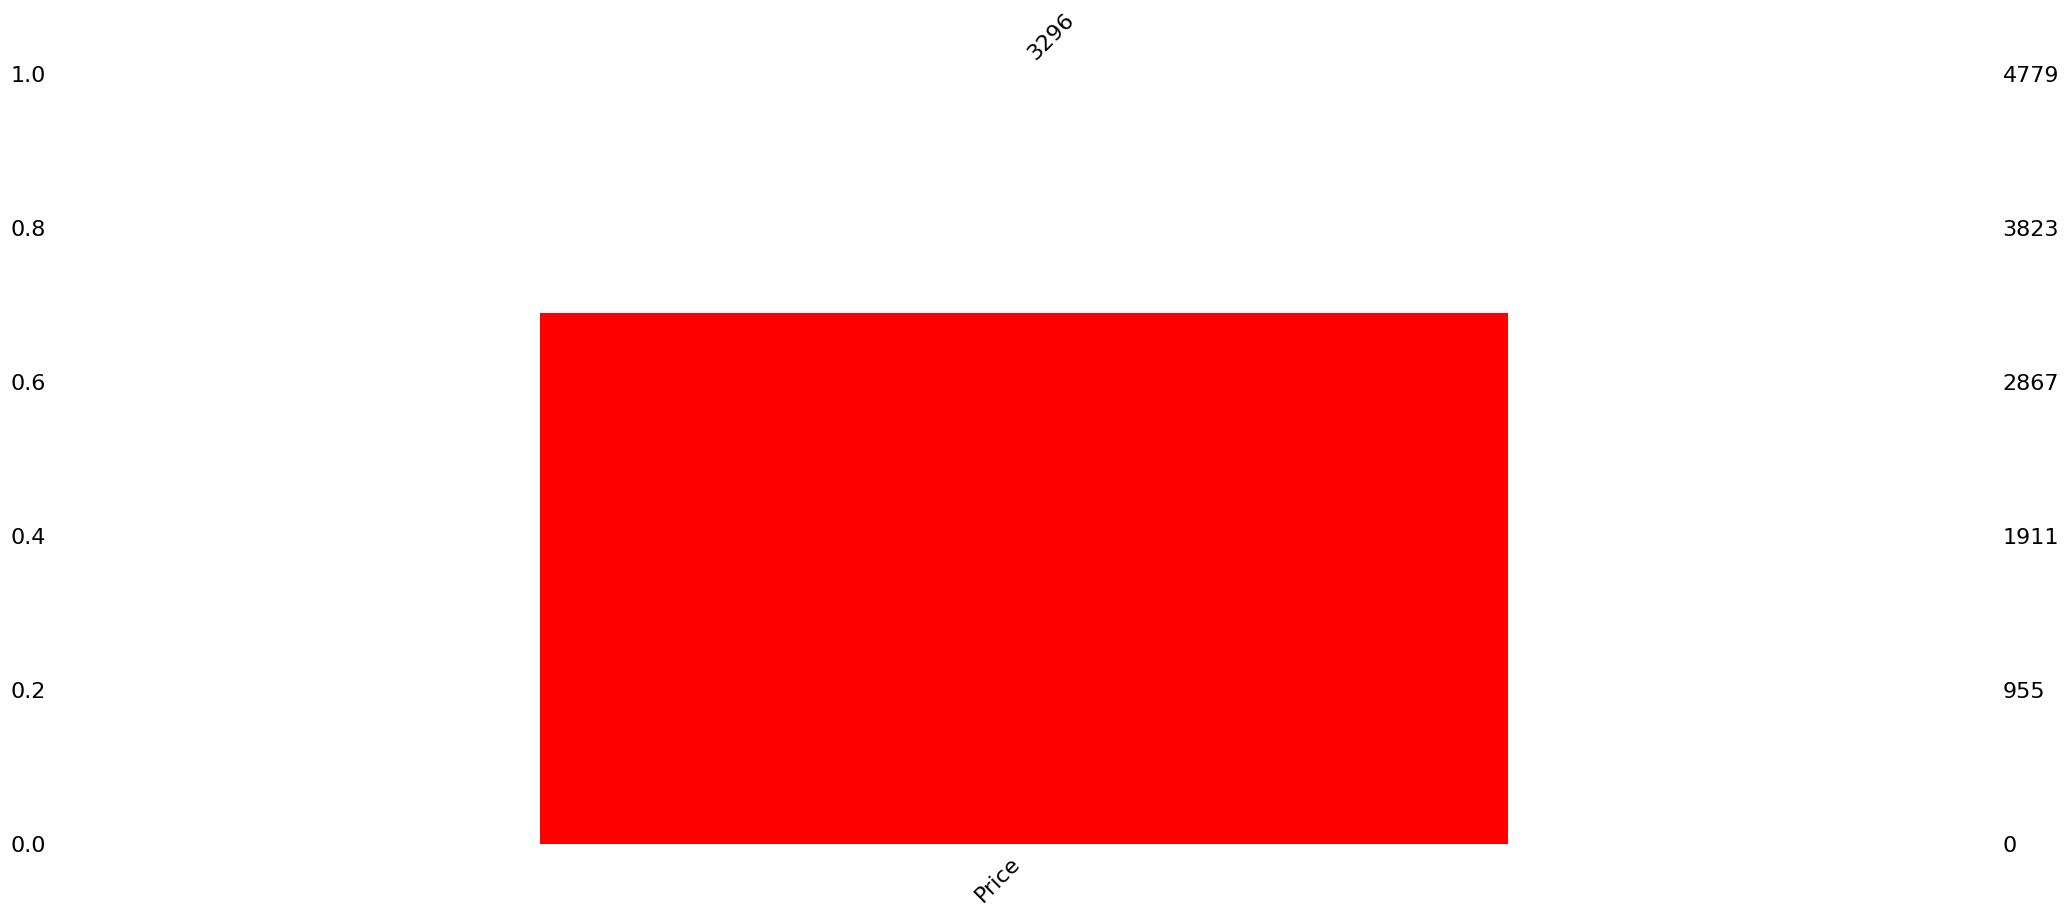

In [74]:
_ = msno.bar(df.resample("D").mean(), color="red")

In [76]:
df.dropna(inplace=True)

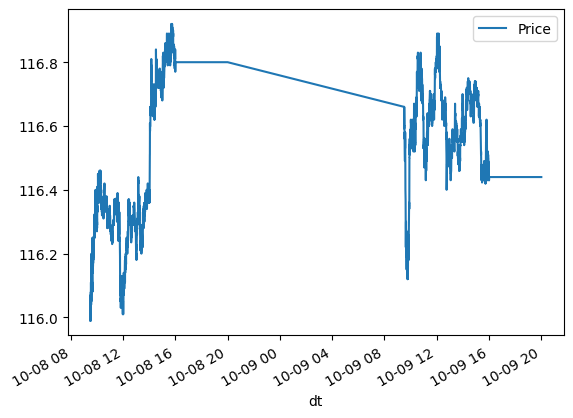

In [66]:
_ = df["2018-10-08 00:00:00" : "2018-10-09 23:59:59"].plot()

In [153]:
HOURS_INDEX = [str(k) for k in list(range(9, 18))]
HOURS_INDEX

['9', '10', '11', '12', '13', '14', '15', '16', '17']

In [154]:
start_dt = "2019-10-10 00:00:00"
end_dt = "2019-10-10 23:59:00"

In [159]:
def plot_price(start_dt: str = "2019-10-09 09:00:00", end_dt: str = "2019-10-09 17:00:00") -> None:
    """
    Function returning the plot
    """
    assert start_dt != end_dt
    data = df[start_dt : end_dt]
    nb_data = len(data)
    _ = plt.figure(figsize=(15, 10))

    ax = data.plot(rot=35)

    t = pd.date_range(start=start_dt,
                  end=end_dt,
                  periods=9)
    _ = ax.set_xticks(t)
    ax.set_xticklabels(HOURS_INDEX)

<Figure size 1500x1000 with 0 Axes>

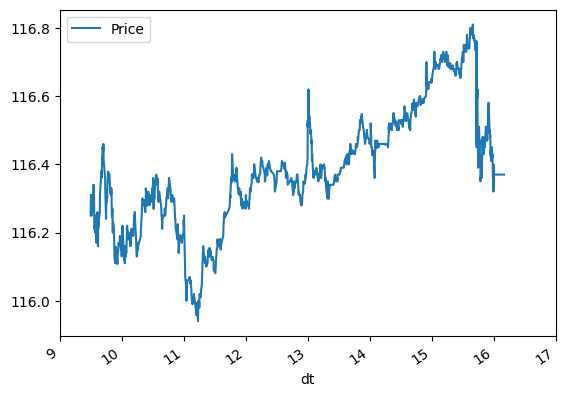

In [160]:
plot_price()

**Remark**: We can observe that the number of trade operations between two different days is not constant and depends on the market participants.

---

**Lucas RODRIGUEZ**